# Benchmark of the external photoevaporation implementation, following the Sellek et al. (2020) 

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import dustpy
from dustpy import Simulation
from dustpy import constants as c


from dustpy import hdf5writer
from dustpy import plot

In [2]:
sp = 17
plt.rc('font', size=sp)                # controls default text sizes
plt.rc('axes', titlesize=sp)           # fontsize of the axes title
plt.rc('axes', labelsize=sp)           # fontsize of the x and y labels
plt.rc('xtick', labelsize=sp)          # fontsize of the tick labels
plt.rc('ytick', labelsize=sp)          # fontsize of the tick labels
plt.rc('legend', fontsize=sp)          # legend fontsize

plt.rc('lines', linewidth=2)

height = 5
width = 8

### Include the external photoevaporation and gas-only setup routines

In [3]:
sys.path.append("../")
from setup_externalPhotoevaporation import setup_externalPhotoevaporation_FRIED
from setup_externalPhotoevaporation import setup_gasonly

# Also import the calculation of the mass loss rate from the FRIED grid
from functions_externalPhotoevaporation import MassLoss_FRIED

## Select an available stellar mass and UV flux

In [4]:
Stellar_Mass = 0.3      # Available stellar masses [Msun]:     [0.05 0.1  0.3  0.5  0.8  1.   1.3  1.6  1.9 ]
UV_Flux = 1.e2          # Available UV fluxes [G0]:          [10.   100.  1000.  5000. 10000.]

## Initialize simulation object

In [5]:
# Physical disk parameters
sim = Simulation()
sim.ini.star.M = Stellar_Mass * c.M_sun     # Stellar mass
sim.ini.gas.Mdisk = 0.1 * sim.ini.star.M    # Initial disk mass
sim.ini.gas.SigmaRc = 60 * c.au             # Initial surface density characteristic radii

In [6]:
# Radial grid parameters
sim.ini.grid.Nr = 100
sim.ini.grid.rmin = 1 * c.au
sim.ini.grid.rmax = 400 * c.au



# Mass grid parameters (shrinked)
sim.ini.grid.Nmbpd = 4
sim.ini.grid.mmin = 1.e-12
sim.ini.grid.mmax = 1.e-9


In [7]:
sim.initialize()

## Setup the external photoevaporation module

In [8]:
setup_externalPhotoevaporation_FRIED(sim, 
                                     fried_filename = "./../friedgrid.dat", 
                                     star_mass = Stellar_Mass, 
                                     UV_flux = UV_Flux, 
                                     factor_SigmaFloor = 1.e-15)
setup_gasonly(sim)
sim.update()

## Benchmark the mass loss grid interpolation
### Recreating Sellek+ (2020) Figure 1

In [9]:
benchmark_radii = sim.grid.r / c.au
benchmark_Sigma = np.logspace(-5, 3, num = 100)
benchmark_MassLoss = MassLoss_FRIED(sim, units_cgs= False, benchmark_Sigma= benchmark_Sigma)

<IPython.core.display.Javascript object>


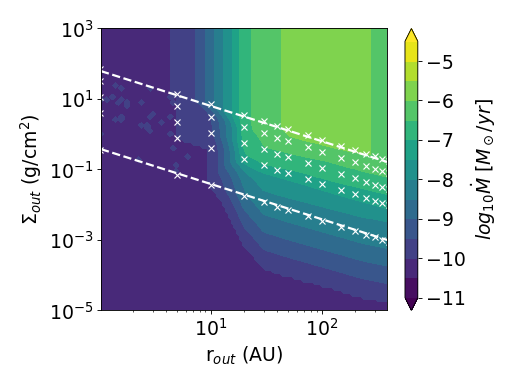

In [10]:
plt.figure()
clim0 = -11.
clim1 = -4
levels = np.arange(clim0, clim1, .5)
cbarTicks = np.arange(clim0, clim1, 1.)

plot00 = plt.contourf(
        benchmark_radii,
        benchmark_Sigma,
        benchmark_MassLoss.T,
        levels=levels,
        extend="both"
        )

plt.plot(sim.grid.r/c.au, sim.FRIED.Limits.Sigma_max, 'w--')
plt.plot(sim.grid.r/c.au, sim.FRIED.Limits.Sigma_min, 'w--')
plt.plot(sim.FRIED.Table.r_out, sim.FRIED.Table.Sigma, 'wx')



plt.xlabel(r"r$_{out}$ (AU)")
plt.ylabel(r"$\Sigma_{out}$ (g/cm$^2$)")
plt.xscale('log')
plt.yscale('log')
plt.xlim(sim.grid.r[0]/c.au, sim.grid.r[-1]/c.au)
cbar00 = plt.colorbar(plot00)
cbar00.set_ticks(cbarTicks)
cbar00.ax.set_ylabel("$log_{10} \dot{M}$ [$M_\odot/yr$]")




plt.tight_layout()


